In [1]:
import pandas as pd
import numpy as np
from ojsim import OJSimulator

sim = OJSimulator()

In [2]:
X, Y = sim.formulized_train

In [3]:
X.shape, Y.shape

((17709, 2, 1440, 10), (17709, 10))

In [4]:
# construct the huge dim input dataset
def transform(X):
    prices = X[:,0,[-30,-1],:]
    price_diff = (X[:,0,1:,:] - X[:,0,:-1,:])[:,-30:,:]
    volu = np.log(X[:,1,:,:] + 1)[:,[-30, -1],:]
    volu_diff = (np.log(X[:,1,1:,:] + 1) - np.log(X[:,1,:-1,:] + 1))[:,-30:,:]
    X_train = np.concatenate([prices, price_diff, volu, volu_diff], axis=1)
    return X_train

X_train = transform(X)
print(X_train.shape)
N, _, _ = X_train.shape

(17709, 64, 10)


In [5]:
y = Y - X[:,0,-1,:]

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
model = []
for i in range(10):
    model.append(LinearRegression().fit(X_train[:,:,i], y[:,i]))
    print(i)

0
1
2
3
4
5
6
7
8
9


In [8]:
for i in range(10):
    print(model[i].score(X_train[:,:,i], y[:,i]))

0.009690666119378633
0.017922249756588404
0.008805042657716422
0.012180069501187996
0.02550292580153013
0.009043094119266182
0.011906997589822055
0.011395441791836824
0.020539089196362048
0.020660068835310796


In [13]:
import pickle
# with open('./linreg.pkl', 'wb') as f:
#     pickle.dump(model, f)
    
with open('./linreg.pkl', 'rb') as f:
    file_model_lsit_linreg = pickle.load(f)

In [14]:
# linear gression with log transform of volumes
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform(X[np.newaxis,:])
    pred = [file_model_lsit_linreg[i].predict(X_test[:,:,i]) for i in range(10)]
    pred = np.array(pred).squeeze()
    pred[-1] *= -1
    return pred

sim.submit(get_r_hat)

Total time used: 8.769s
Pairwise correlation:
	asset 0 = 0.02564
	asset 1 = 0.02618
	asset 2 = 0.04222
	asset 3 = 0.02167
	asset 4 = 0.04059
	asset 5 = 0.00099
	asset 6 = 0.03709
	asset 7 = 0.02273
	asset 8 = 0.10547
	asset 9 = 0.00042
	mean correlation = 0.03230
Overall correlation: 0.02001
Performance beats Ziwei's dummy method!


In [12]:
combined_model = LinearRegression().fit(X_train.reshape(N, -1), y)
print(combined_model.score(X_train.reshape(N,-1), y))
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform(X[np.newaxis,:])
    pred = combined_model.predict(X_test.reshape(1, -1))
    return pred

sim.submit(get_r_hat)

0.06479578972014496
Total time used: 5.340s
Pairwise correlation:
	asset 0 = -0.00324
	asset 1 = 0.00814
	asset 2 = 0.02628
	asset 3 = 0.01886
	asset 4 = 0.05164
	asset 5 = -0.00850
	asset 6 = 0.02036
	asset 7 = 0.01185
	asset 8 = 0.01591
	asset 9 = 0.00457
	mean correlation = 0.01459
Overall correlation: -0.00192
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


In [50]:
# new transform and tests
# construct the huge dim input dataset
def transform_split(X):
    prices = X[:,0,[-30,-1],:]
    price_diff = (X[:,0,1:,:] - X[:,0,:-1,:])[:,-30:,:]
    volu = np.log(X[:,1,:,:] + 1)[:,[-30, -1],:]
    volu_diff = (np.log(X[:,1,1:,:] + 1) - np.log(X[:,1,:-1,:] + 1))[:,-30:,:]
    
    X_train = np.concatenate([prices, price_diff, volu, volu_diff], axis=1)
    X_train_off49 = np.delete(X_train, [4, 9], axis=2)
    X_train_4 = np.concatenate([X_train[:,:,4], 
                                price_diff[:,:,[1,2,6,7]].sum(axis=1),
                                volu_diff[:,:,[1,2,6,7]].sum(axis=1),
                                prices[:,:,[1,2,6,7]].reshape(len(X_train),-1),
                                volu[:,:,[1,2,6,7]].reshape(len(X_train),-1)], axis=1)
    X_train_9 = np.concatenate([X_train[:,:,9],
                               X_train[:,:,:-1].reshape(len(X_train), -1)], axis=1)
    X_train_final = [X_train_off49[:,:,i] for i in range(8)]
    X_train_final.insert(4, X_train_4)
    X_train_final.insert(9, X_train_9)
    return X_train_final

X_train = transform_split(X)
for i in range(10):
    print(X_train[i].shape)

(17709, 64)
(17709, 64)
(17709, 64)
(17709, 64)
(17709, 88)
(17709, 64)
(17709, 64)
(17709, 64)
(17709, 64)
(17709, 640)


In [53]:
model = []
for i in range(10):
    if i == 5:
        model.append(KernelRidge(kernel='poly', degree=2).fit(X_train[i], y[:,i]))
    else:
        model.append(LinearRegression().fit(X_train[i], y[:,i]))
    print(i)


0
1
2
3
4
5
6
7
8
9


In [54]:
for i in range(10):
    print(model[i].score(X_train[i], y[:,i]))

0.009676521180743247
0.01791763328553353
0.008799428121327613
0.012186065859909445
0.03099024685885632
0.02012710785808347
0.011916743980277977
0.011395409452926497
0.020539209904011924
0.08217221220902382


In [38]:
import pickle
# with open('./splilt_linreg.pkl', 'wb') as f:
#     pickle.dump(model, f)

with open('./splilt_linreg.pkl', 'rb') as f:
    file_split_model_lsit = pickle.load(f)


In [49]:
# split models
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform_split(X[np.newaxis,:])
    pred = [file_split_model_lsit[i].predict(X_test[i]) for i in range(10)]
#     pred = np.array(pred, dtype=float).squeeze()
    return pred

sim.submit(get_r_hat)

Total time used: 9.431s
Pairwise correlation:
	asset 0 = 0.02558
	asset 1 = 0.02629
	asset 2 = 0.04226
	asset 3 = 0.02170
	asset 4 = 0.05511
	asset 5 = 0.00099
	asset 6 = 0.03712
	asset 7 = 0.02273
	asset 8 = 0.10547
	asset 9 = 0.00434
	mean correlation = 0.03416
Overall correlation: 0.02109
Performance beats Ziwei's dummy method!


In [58]:
import pickle
with open('./splilt_kernel_5.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('./splilt_kernel_5.pkl', 'rb') as f:
    file_split_kernel_lsit = pickle.load(f)


In [59]:
# split models
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform_split(X[np.newaxis,:])
    pred = [file_split_kernel_lsit[i].predict(X_test[i]) for i in range(10)]
#     pred = np.array(pred, dtype=float).squeeze()
    return pred

sim.submit(get_r_hat)

Total time used: 19.083s
Pairwise correlation:
	asset 0 = 0.02558
	asset 1 = 0.02629
	asset 2 = 0.04226
	asset 3 = 0.02170
	asset 4 = 0.05511
	asset 5 = 0.01427
	asset 6 = 0.03712
	asset 7 = 0.02273
	asset 8 = 0.10547
	asset 9 = 0.00434
	mean correlation = 0.03549
Overall correlation: 0.02159
Performance beats Ziwei's dummy method!


In [56]:
# SAFE HOUSE SAFE HOUSE SAFE HOUSE SAFE HOUSE SAFE HOUSE SAFE HOUSE 
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform_split(X[np.newaxis,:])
    pred = [model[i].predict(X_test[i]) for i in range(10)]
    return pred

sim.submit(get_r_hat)

Total time used: 19.240s
Pairwise correlation:
	asset 0 = 0.02558
	asset 1 = 0.02629
	asset 2 = 0.04226
	asset 3 = 0.02170
	asset 4 = 0.05511
	asset 5 = 0.01427
	asset 6 = 0.03712
	asset 7 = 0.02273
	asset 8 = 0.10547
	asset 9 = 0.00434
	mean correlation = 0.03549
Overall correlation: 0.02159
Performance beats Ziwei's dummy method!


In [43]:
# try non linear models
from sklearn.kernel_ridge import KernelRidge
model = []
for i in range(10):
    model.append(KernelRidge(kernel='poly', degree=2).fit(X_train[i], y[:,i]))
    print(i)

0
1
2
3
4
5
6
7
8
9


In [44]:
for i in range(10):
    print(model[i].score(X_train[i], y[:,i]))

0.021815462630938587
0.02786426519830909
0.020971973061282623
0.021265161619796857
0.053389870950105944
0.02012710785808347
0.021551771690593524
0.024032187227825186
0.02217689145379309
0.12114119124956124


In [46]:
# kernel ridge
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform_split(X[np.newaxis,:])
    pred = [model[i].predict(X_test[i]) for i in range(10)]
    return pred

sim.submit(get_r_hat)

Total time used: 289.629s
Pairwise correlation:
	asset 0 = -0.00643
	asset 1 = 0.02302
	asset 2 = 0.03490
	asset 3 = 0.02302
	asset 4 = 0.02164
	asset 5 = 0.01427
	asset 6 = 0.02749
	asset 7 = 0.00125
	asset 8 = 0.01589
	asset 9 = 0.01368
	mean correlation = 0.01687
Overall correlation: 0.00811
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)


In [13]:
# Logistic regression without log volumes
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform_split(X[np.newaxis,:])
    pred = np.array([model_logistic[i].predict(X_test[:,:,i]) for i in range(10)], dtype=float)
    pred = (pred.squeeze() - 0.5) * 2 * A.values.max(axis=0) + np.random.randn(10) * 1e-8
    return pred

sim.submit(get_r_hat)

(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760, 10)
(1, 2, 2880, 10)
(1, 5760

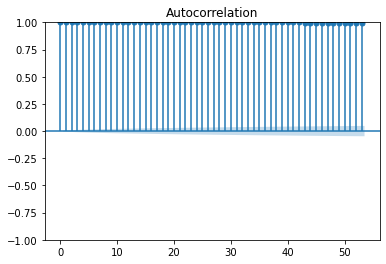

In [21]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

log_pr, volu_pr = sim.train
plot_acf(log_pr[0])
plt.show()

In [26]:
last_price = X[:,0,-1,:]
print(last_price.shape, y.shape)

(17709, 10) (17709, 10)


In [38]:
res = np.corrcoef(last_price[:,0], y[:,7])
print(res.shape)
print(res)

(2, 2)
[[1.         0.75285691]
 [0.75285691 1.        ]]


In [40]:
fitted = LinearRegression().fit(last_price, y)
error = y - fitted.predict(last_price)

In [43]:
second_last_price = X[:,0,-2,:]
print(second_last_price.shape)

(17709, 10)


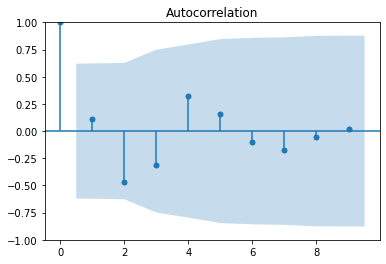

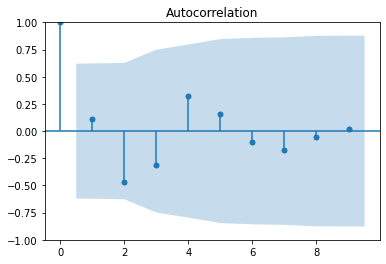

In [46]:
plot_acf(error[0])

In [17]:
# using only the last price to predict
model = LinearRegression().fit(X_train.reshape(len(X_train), -1), y)

In [18]:
model.score(X_train.reshape(len(X_train), -1), y)

0.9985892808567882

In [80]:
# test dependencies on the diff
diff_price = X[:,0,1:,:] - X[:,0,:-1,:]
last_diff = diff_price[:,-1,:]
np.corrcoef(last_diff[:,0], y[:,0])

array([[ 1.        , -0.00776907],
       [-0.00776907,  1.        ]])

In [71]:
# linear gression with only last price and the 30th last price
# ####################################################
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform(X[np.newaxis,:])
    pred = model.predict(X_test.reshape(len(X_test), -1))
    return pred - A.values[-1]

sim.submit(get_r_hat)

(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


In [75]:
# linear gression with only ::30
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform(X[np.newaxis,:])
    pred = model.predict(X_test.reshape(len(X_test), -1))
    return pred - A.values[-1]

sim.submit(get_r_hat)

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 192, 10)
(1, 2, 96, 10)
(1, 1

In [81]:
# linear gression with only last price and the 30th last price no diff
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform(X[np.newaxis,:])
    pred = model.predict(X_test.reshape(len(X_test), -1))
    return pred - A.values[-1]

sim.submit(get_r_hat)

(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)
(1, 2, 2, 10)
(1, 4, 10)


In [85]:
# linear gression with 1, 29, -1, -30
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform(X[np.newaxis,:])
    pred = model.predict(X_test.reshape(len(X_test), -1))
    return pred - A.values[-1]

sim.submit(get_r_hat)

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10)
(1, 16, 10)
(1, 2, 8, 10

In [90]:
# Try logistic regression without log volumes
from sklearn.linear_model import LogisticRegression
y_logistic = (y > 0).astype(int)
model_logistic = []
print(X_train.shape)
for i in range(10):
    model_logistic.append(LogisticRegression().fit(X_train[:,:,i], y_logistic[:,i]))
    print(i)

(17709, 8, 10)
0
1
2
3
4
5
6
7
8
9


In [93]:
# Logistic regression without log volumes
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform(X[np.newaxis,:])
    pred = np.array([model_logistic[i].predict(X_test[:,:,i]) for i in range(10)], dtype=float)
    pred = (pred.squeeze() - 0.5) * 2 * A.values.max(axis=0) + np.random.randn(10) * 1e-8
    return pred - A.values[-1]

sim.submit(get_r_hat)

(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)
(1, 2, 4, 10)
(1, 8, 10)


In [32]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train.reshape(len(X_train),-1), y)
y.shape

(17709, 10)

In [33]:
model.score(X_train.reshape(len(X_train), -1), y)

0.9985892278993012

In [30]:
# checks for more volume
# linear gression with only last price and the 30th last price
# ####################################################
def get_r_hat(A, B):
    X = np.stack([A.values, B.values], axis=0)
    X_test = transform(X[np.newaxis,:])
    pred = model.predict(X_test.reshape(len(X_test), -1))
    return pred - A.values[-1]

sim.submit(get_r_hat)

Total time used: 3.171s
Pairwise correlation:
	asset 0 = 0.00655
	asset 1 = 0.00704
	asset 2 = -0.02376
	asset 3 = -0.02055
	asset 4 = -0.00305
	asset 5 = -0.00693
	asset 6 = 0.00049
	asset 7 = -0.01817
	asset 8 = -0.03639
	asset 9 = -0.03210
	mean correlation = -0.01269
Overall correlation: -0.00804
Fail to outperform Ziwei's method, whose pairwise average
and overall correlations are (0.02840, 0.01536)
